<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Mosquitoes

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import datetime
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import dates, cm
from geopy.distance import geodesic

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None  # default='warn'

# Read in data files

In [2]:
test = pd.read_csv('../assets/test.csv/test.csv')
test.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [3]:
spray = pd.read_csv('../assets/processed_data/spray_processed.csv')
spray['lat_long'] = list(zip(spray['Latitude'], spray['Longitude'])) # to compute distances later
spray.head()

,Latitude,Longitude,lat_long
0,41.981433,-87.787777,"(41.9814333333333, -87.7877766666667)"
1,41.980998,-87.787778,"(41.9809983333333, -87.7877783333333)"
2,41.980560,-87.787762,"(41.98056, -87.7877616666667)"
3,41.980198,-87.787758,"(41.9801983333333, -87.7877583333333)"
4,41.979752,-87.787765,"(41.9797516666667, -87.787765)"


In [4]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14199 entries, 0 to 14198
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14199 non-null  float64
 1   Longitude  14199 non-null  float64
 2   lat_long   14199 non-null  object 
dtypes: float64(2), object(1)
memory usage: 332.9+ KB


In [5]:
weather = pd.read_csv('../assets/processed_data/weather_processed.csv')
weather['Date'] = pd.to_datetime(weather['Date'])
weather.head()

,Date,Tavg,DewPoint,WetBulb,PrecipTotal,AvgSpeed
0,2007-05-01,67.50,51.0,56.5,0.0,9.40
1,2007-05-02,51.50,42.0,47.0,0.0,13.40
2,2007-05-03,57.00,40.0,49.0,0.0,12.55
3,2007-05-04,61.25,41.5,50.0,0.0,10.60
4,2007-05-05,60.00,38.5,49.5,0.0,11.75


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tavg         1472 non-null   float64       
 2   DewPoint     1472 non-null   float64       
 3   WetBulb      1472 non-null   float64       
 4   PrecipTotal  1472 non-null   float64       
 5   AvgSpeed     1472 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 69.1 KB


In [7]:
wnv_density = pd.read_csv('../assets/processed_data/wnv_density_processed.csv')
wnv_density.columns = ['year', 'Address', 'wnv_density']
wnv_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         343 non-null    int64 
 1   Address      343 non-null    object
 2   wnv_density  343 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.2+ KB


In [8]:
ada_final = pickle.load(open('../models/adaboost_tuned.sav', 'rb'))

# Engineer Features

In [9]:
test['Date'] = pd.to_datetime(test['Date'])
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year - 1 # preceding year

In [10]:
# Merge in wnv density data on year and trap address
test_wnv = test.merge(wnv_density, how='left', left_on = ['year', 'Address'], right_on = ['year', 'Address'])
test_wnv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [11]:
test_wnv.fillna(0, inplace=True) # fill with 0 for those rows with no match

In [12]:
# define function to check whether two lat-long coordinates are within 50 metres. Output 1 if so, else 0

def check_within_50m(coord):
    
    for spray_coord in spray['lat_long']:
        if geodesic(coord, spray_coord).meters <= 50:
            return 1
    return 0

In [13]:
# To reduce computing time, we first take all distinct lat-long combinations to compute distances, since there are many repeat locations in the train dataset

test_latlong = test[['Latitude', 'Longitude']].drop_duplicates(subset=['Latitude', 'Longitude']).reset_index(drop=True)
test_latlong['lat_long'] = list(zip(test_latlong['Latitude'], test_latlong['Longitude']))

In [14]:
test_latlong.head(1)

,Latitude,Longitude,lat_long
0,41.95469,-87.800991,"(41.95469, -87.800991)"


In [15]:
# Takes awhile to run
test_latlong['spray_indicator'] = test_latlong['lat_long'].apply(check_within_50m)

In [16]:
test_latlong.spray_indicator.value_counts()

0    130
1     21
Name: spray_indicator, dtype: int64

In [17]:
test_wnv_spray = test_wnv.merge(test_latlong, how='left', left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])
test_wnv_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [18]:
def get_weather(ls_date):
    '''
    This function takes in a list of dates and returns the preceding 30-day averages of 5 weather indicators: temperature, dew point, wetbulb,
    precipitation (total instead of average), wind speed.
    
    Returns one list for each indicator.
    '''
    temp_list = []
    dewpt_list = []
    wetbulb_list = []
    precip_list = []
    windspeed_list = []
    
    for date in ls_date:
        date = pd.to_datetime(date)
        weather_subset = weather[(weather['Date'] <= date + pd.Timedelta(days=-1)) & (weather['Date'] >= date + pd.Timedelta(days=-31))]
        
        temp_list.append(weather_subset['Tavg'].mean())
        dewpt_list.append(weather_subset['DewPoint'].mean())
        wetbulb_list.append(weather_subset['WetBulb'].mean())
        precip_list.append(weather_subset['PrecipTotal'].sum())
        windspeed_list.append(weather_subset['AvgSpeed'].mean())

    return temp_list, dewpt_list, wetbulb_list, precip_list, windspeed_list

In [19]:
avg_temp, avg_dewpt, avg_wetbulb, tot_precip, avg_windspeed = get_weather(test_wnv_spray['Date'])

In [20]:
test_wnv_spray['avg_temp'] = avg_temp
test_wnv_spray['avg_dewpt'] = avg_dewpt
test_wnv_spray['avg_wetbulb'] = avg_wetbulb
test_wnv_spray['tot_precip'] = tot_precip
test_wnv_spray['avg_windspeed'] = avg_windspeed

In [21]:
test_wnv_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [22]:
test_wnv_spray.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,month,year,wnv_density,lat_long,spray_indicator,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323


In [23]:
# Retain final variables

test_final = test_wnv_spray[['Id', 'Species', 'month', 'wnv_density', 'spray_indicator', 'avg_temp', 'avg_dewpt', 'avg_wetbulb',
       'tot_precip', 'avg_windspeed']]
test_final.shape

(116293, 10)

In [24]:
test_final.head()

,Id,Species,month,wnv_density,spray_indicator,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed
0,1,CULEX PIPIENS/RESTUANS,6,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323
1,2,CULEX RESTUANS,6,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323
2,3,CULEX PIPIENS,6,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323
3,4,CULEX SALINARIUS,6,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323
4,5,CULEX TERRITANS,6,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323


# One hot encoding

In [25]:
test_final = pd.get_dummies(test_final, columns=['Species', 'month'])
print(test_final.shape)
test_final.head()

(116293, 21)


,Id,wnv_density,spray_indicator,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,month_6,month_7,month_8,month_9,month_10
0,1,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,1,0,0,0,0,1,0,0,0,0
2,3,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323,0,1,0,0,0,0,0,0,1,0,0,0,0
3,4,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,0,1,0,0,0,1,0,0,0,0
4,5,8.0,0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,0,0,0,1,0,1,0,0,0,0


In [26]:
test_final.drop(columns=['avg_dewpt', 'avg_wetbulb', 'Species_UNSPECIFIED CULEX'], inplace=True)
print(test_final.shape)

(116293, 18)


# Make predictions

In [27]:
test_final['WnvPresent'] = ada_final.predict_proba(test_final.drop(columns=['Id']))[:,1]

In [28]:
test_final.head()

,Id,wnv_density,spray_indicator,avg_temp,tot_precip,avg_windspeed,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,month_6,month_7,month_8,month_9,month_10,WnvPresent
0,1,8.0,0,61.064516,4.97,10.340323,0,0,1,0,0,0,0,1,0,0,0,0,0.166572
1,2,8.0,0,61.064516,4.97,10.340323,0,0,0,1,0,0,0,1,0,0,0,0,0.148925
2,3,8.0,0,61.064516,4.97,10.340323,0,1,0,0,0,0,0,1,0,0,0,0,0.166155
3,4,8.0,0,61.064516,4.97,10.340323,0,0,0,0,1,0,0,1,0,0,0,0,0.132262
4,5,8.0,0,61.064516,4.97,10.340323,0,0,0,0,0,0,1,1,0,0,0,0,0.124651


In [29]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              116293 non-null  int64  
 1   wnv_density                     116293 non-null  float64
 2   spray_indicator                 116293 non-null  int64  
 3   avg_temp                        116293 non-null  float64
 4   tot_precip                      116293 non-null  float64
 5   avg_windspeed                   116293 non-null  float64
 6   Species_CULEX ERRATICUS         116293 non-null  uint8  
 7   Species_CULEX PIPIENS           116293 non-null  uint8  
 8   Species_CULEX PIPIENS/RESTUANS  116293 non-null  uint8  
 9   Species_CULEX RESTUANS          116293 non-null  uint8  
 10  Species_CULEX SALINARIUS        116293 non-null  uint8  
 11  Species_CULEX TARSALIS          116293 non-null  uint8  
 12  Species_CULEX TE

# Output predictions to CSV

In [30]:
test_final[['Id', 'WnvPresent']].to_csv('../assets/predictions/submission.csv', index=False)

# Where should we spray?

In [31]:
street_map = gpd.read_file('../assets/geo_export_a6957f22-b168-4cee-b03c-0bcc9815308c.shp')

geometry = [Point(xy) for xy in zip(test['Longitude'], test['Latitude'])]

geo_test = gpd.GeoDataFrame(test,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry)

geo_test['WnvPresent'] = test_final['WnvPresent']
geo_test['WnvPresent'] = geo_test['WnvPresent'].apply(lambda x: 1 if x >= 0.5 else 0)

C:\Users\Darre\.conda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [32]:
geo_test.head(1)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,month,year,geometry,WnvPresent
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,POINT (-87.80099 41.95469),0


In [33]:
# create 1 dataframe, 1 for each year
geo_test_groupby_2008_WNV = geo_test[geo_test['Date'].dt.year==2008].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2008_WNV = geo_test_groupby_2008_WNV[geo_test_groupby_2008_WNV['WnvPresent'] > 0]

geo_test_groupby_2010_WNV = geo_test[geo_test['Date'].dt.year==2010].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2010_WNV = geo_test_groupby_2010_WNV[geo_test_groupby_2010_WNV['WnvPresent'] > 0]

geo_test_groupby_2012_WNV = geo_test[geo_test['Date'].dt.year==2012].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2012_WNV = geo_test_groupby_2012_WNV[geo_test_groupby_2012_WNV['WnvPresent'] > 0]

geo_test_groupby_2014_WNV = geo_test[geo_test['Date'].dt.year==2014].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2014_WNV = geo_test_groupby_2014_WNV[geo_test_groupby_2014_WNV['WnvPresent'] > 0]

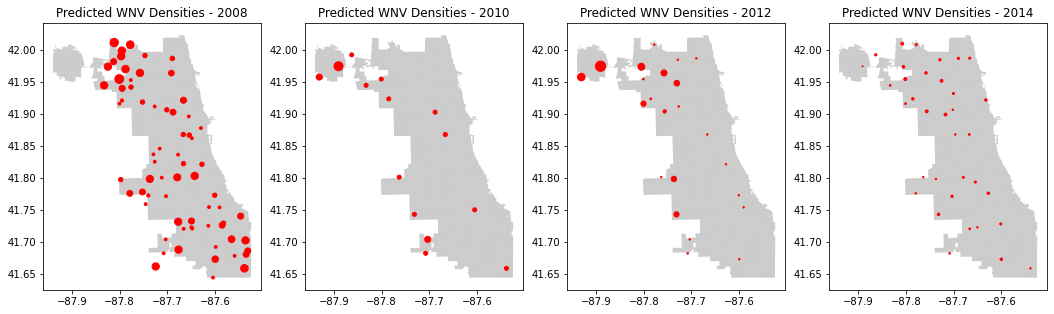

In [34]:
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')
street_map.plot(ax=ax[2], alpha=0.4, color='grey')
street_map.plot(ax=ax[3], alpha=0.4, color='grey')

geo_test_groupby_2008_WNV.plot(ax=ax[0], markersize=(geo_test_groupby_2008_WNV['WnvPresent']).values, color='red', marker='o')
ax[0].set_title('Predicted WNV Densities - 2008')

geo_test_groupby_2010_WNV.plot(ax=ax[1], markersize=(geo_test_groupby_2010_WNV['WnvPresent']).values, color='red', marker='o')
ax[1].set_title('Predicted WNV Densities - 2010')

geo_test_groupby_2012_WNV.plot(ax=ax[2], markersize=(geo_test_groupby_2012_WNV['WnvPresent']).values, color='red', marker='o')
ax[2].set_title('Predicted WNV Densities - 2012')

geo_test_groupby_2014_WNV.plot(ax=ax[3], markersize=(geo_test_groupby_2014_WNV['WnvPresent']).values, color='red', marker='o')
ax[3].set_title('Predicted WNV Densities - 2014')

fig.savefig('../charts/12.jpg')